In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

# Potential flow around a cylinder

2D flow in a plane around a cylinder. Full setup for the problem is nicely explained here: https://en.wikipedia.org/wiki/Potential_flow_around_a_circular_cylinder

Mathematical derivation for the exact solution can be found here: https://courses.seas.harvard.edu/climate/eli/Courses/APM105/Sources/08-PDEs/03-Laplace/notes-potential-flow-around-cylinder.pdf

The exact solution is usually calculated using polar coordinates.
We make a few assumptions:
- The flow has no vorticity and the liquid is assumed to be incompressible ($\nabla^2\phi = 0$).
- Far away from the cylinder, the flow is uniform with magnitude U.
- The cylinder has radius R.

We will skip straight to the solution, which is governed by the following equation. The equation is phrased in terms of the
velocity potential $\phi$, which can differentiated to find the Velocity components in the $r$ and $\theta$ directions. I have copied the below code for the analytical solution from: http://flothesof.github.io/2D-potential-flow-finite-differences.html


$$\phi (r,\theta )=Ur\left(1+{\frac {R^{2}}{r^{2}}}\right)\cos \theta \,.$$
$$V_{r}={\frac {\partial \phi }{\partial r}}=U\left(1-{\frac {R^{2}}{r^{2}}}\right)\cos \theta $$
$$ V_{\theta }={\frac {1}{r}}{\frac {\partial \phi }{\partial \theta }}=-U\left(1+{\frac {R^{2}}{r^{2}}}\right)\sin \theta \,.$$

The PDE which we are trying to solve is Laplace's equation ($\nabla^2\phi = 0$). In polar coordinates, $\nabla^2\phi$ is equal to:

$$
\nabla^2\phi = \frac{\partial^2\phi}{\partial r^2} + \frac{1}{r}\frac{\partial \phi}{\partial r} + \frac{1}{r^2}\frac{\partial^2 \phi}{\partial\theta^2} = 0
$$
In Cartesian 2D coordinates, $\nabla^2\phi$ is equal to:
$$
\nabla^2\phi = \frac{\partial^2\phi}{\partial x^2}  + \frac{\partial^2 \phi}{\partial y^2} = 0
$$

## Exact solution

In [5]:
def make_grid(Lx=4, Ly=5, nx=50, ny=51):
    """Make a rectangular grid, with coordinates centered on (0, 0)."""
    x = np.linspace(0, Lx, num=nx) - Lx/2
    y = np.linspace(0, Ly, num=ny) - Ly/2
    X, Y = np.meshgrid(x, y)
    return X, Y

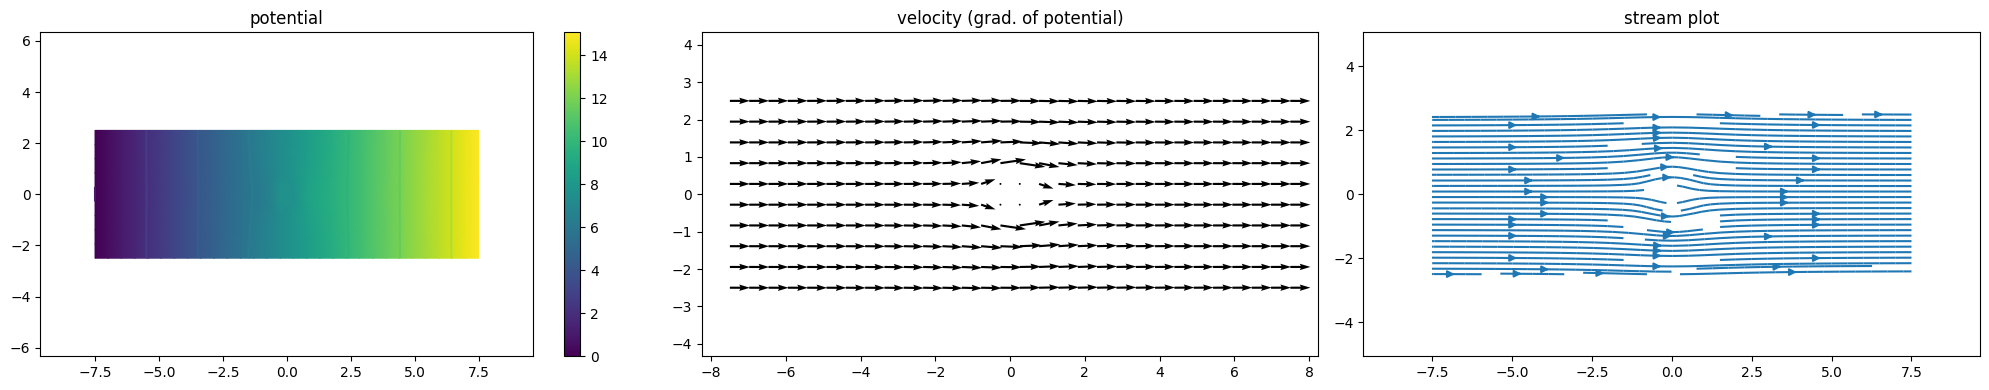

In [46]:
def compute_analytical_solution(grid, U, R):
    """Applies analytical solution of cylinder flow to every point in the grid."""
    X, Y = grid
    r = np.sqrt(X**2 + Y**2)
    theta = np.arctan2(Y, X)
    phi = U * r * (1 + R**2/r**2) * np.cos(theta) * (r > R)
    phi -= phi.min() # normalizing by minimum value
    v_r = U * (1 - R**2 / r**2) * np.cos(theta) * (r > R)
    v_theta = -U * (1 + R**2 / r**2) * np.sin(theta) * (r > R)
    v_x = np.cos(theta) * v_r - np.sin(theta) * v_theta
    v_y = np.sin(theta) * v_r + np.cos(theta) * v_theta

    return phi, v_x, v_y

def compute_gradient(grid, phi):
    """Numerically computes velocity as gradient of phi on grid."""
    X, Y = grid
    dx = X[0, 1] - X[0, 0]
    dy = Y[1, 0] - Y[0, 0]
    v, u = np.gradient(phi, dx, dy)
    return u, v

def make_plot(phi_mapped, grid, uv=None):
    """Plots a solution to the potential flow on the grid."""
    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(20, 4))
    m = ax1.pcolormesh(grid[0], grid[1], phi_mapped, shading='Gouraud')
    ax1.contour(grid[0], grid[1], phi_mapped, vmin=-1, vmax=16)
    plt.colorbar(m, ax=ax1)
    ax1.axis('equal')
    ax1.set_title("potential")

    if uv is not None:
        u, v = uv
    else:
        u, v = compute_gradient(grid, phi_mapped)

    ax2.quiver(grid[0], grid[1], u, v)
    ax2.set_title("velocity (grad. of potential)");
    ax2.axis('equal')
    ax3.streamplot(grid[0], grid[1], u, v)
    ax3.set_title('stream plot')
    ax3.axis('equal')
    plt.tight_layout()

grid = make_grid(Lx=15, Ly=5, nx=30, ny=10)
phi_exact, v_x_exact, v_y_exact = compute_analytical_solution(grid, U=1, R=0.5)

make_plot(phi_exact, grid, uv=(v_x_exact, v_y_exact))

In [7]:
# Get channel boundary.
def get_channel_boundary(grid):
    xs = grid[0]
    ys = grid[1]

    # Extract inlet coordinates.
    inlet_x = xs[0, 0]
    inlet_ys = ys[:, 0]
    inlet_xys = np.zeros((inlet_ys.shape[0], 2))
    inlet_xys[:, 0] = inlet_x
    inlet_xys[:, 1] = inlet_ys

    # Extract outlet coordinates.
    outlet_x = xs[0, -1]
    outlet_ys = ys[:, -1]
    outlet_xys = np.zeros((outlet_ys.shape[0], 2))
    outlet_xys[:, 0] = outlet_x
    outlet_xys[:, 1] = outlet_ys

    # Extract channel left wall.
    left_wall_xs = xs[-1, :]
    left_wall_y = ys[-1, 0]
    left_wall_xys = np.zeros((left_wall_xs.shape[0], 2))
    left_wall_xys[:, 0] = left_wall_xs
    left_wall_xys[:, 1] = left_wall_y

    # Extract channel right wall.
    right_wall_xs = xs[0, :]
    right_wall_y = ys[0, 0]
    right_wall_xys = np.zeros((right_wall_xs.shape[0], 2))
    right_wall_xys[:, 0] = right_wall_xs
    right_wall_xys[:, 1] = right_wall_y

    return inlet_xys, outlet_xys, left_wall_xys, right_wall_xys

In [8]:
inlet_xys, outlet_xys, left_wall_xys, right_wall_xys = get_channel_boundary(grid)

In [9]:
def get_cylinder_boundary(radius, center, nr_ps):

    thetas = np.linspace(0, 2*np.pi, nr_ps)

    circle_xys = np.zeros((nr_ps, 2))

    circle_xys[:, 0] = center[0] + radius * np.cos(thetas)
    circle_xys[:, 1] = center[1] + radius * np.sin(thetas)

    return circle_xys, thetas


In [10]:
cylinder_xys, thetas = get_cylinder_boundary(0.5, [0, 0], 10)

In [11]:
def get_cylinder_normals(radius, thetas, circle_xys):
    dx_dtheta = radius * np.sin(thetas)
    dy_dtheta = -radius * np.cos(thetas)
    normal_vectors = np.array([(-dy_dtheta[i], dx_dtheta[i]) for i in range(len(thetas))])
    normal_vectors[:, 0] = normal_vectors[:, 0] + circle_xys[:, 0]
    normal_vectors[:, 1] = normal_vectors[:, 1] + circle_xys[:, 1]
    norms = np.linalg.norm(normal_vectors, axis=1)
    normal_vectors = normal_vectors / norms[:, np.newaxis]


    return normal_vectors

In [12]:
cylinder_normals = get_cylinder_normals(1, thetas, cylinder_xys)

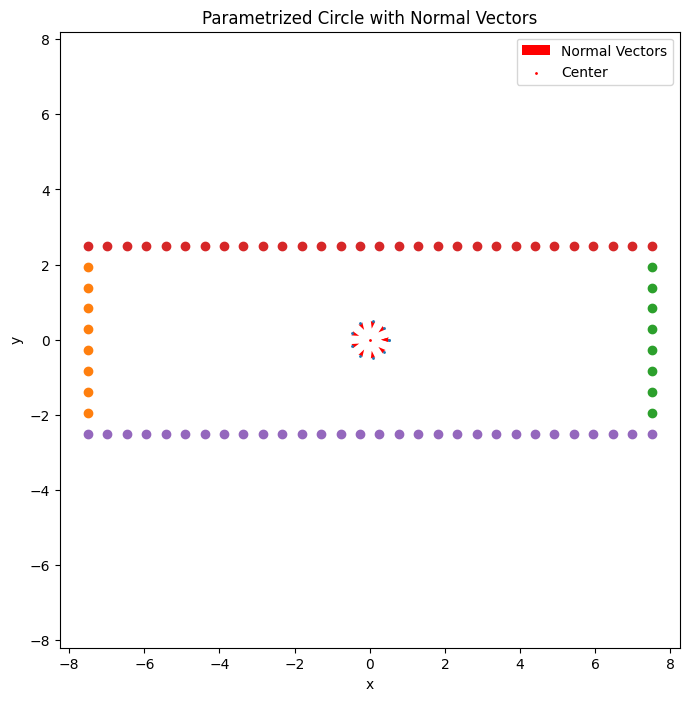

In [13]:
# Plot the circle and normal vectors
plt.figure(figsize=(8, 8))
plt.quiver(cylinder_xys[:, 0], cylinder_xys[:, 1], -cylinder_normals[:, 0], -cylinder_normals[:, 1], color='red', scale=5, scale_units='xy', angles='xy', label='Normal Vectors')
plt.scatter(*(0,0), color='red', label='Center', s=1)
plt.title('Parametrized Circle with Normal Vectors')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.axis('equal')

plt.scatter(cylinder_xys[:, 0], cylinder_xys[:, 1], s=1)
plt.scatter(inlet_xys[1:-1, 0], inlet_xys[1:-1, 1]) # Exclude top and bottom points, corresponding to the wall.
plt.scatter(outlet_xys[1:-1, 0], outlet_xys[1:-1, 1]) # Exclude top and bottom points, corresponding to the wall.
plt.scatter(left_wall_xys[:, 0], left_wall_xys[:, 1])
plt.scatter(right_wall_xys[:, 0], right_wall_xys[:, 1])
plt.show()

## Inverse PINN to infer U and/or R

### First define a fully connect network
### Then train the PINN

In [42]:
# define network architecture

class FullyConnected(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )

    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.hidden(x)
    x = self.output(x)
    return x

torch.Size([400, 2])


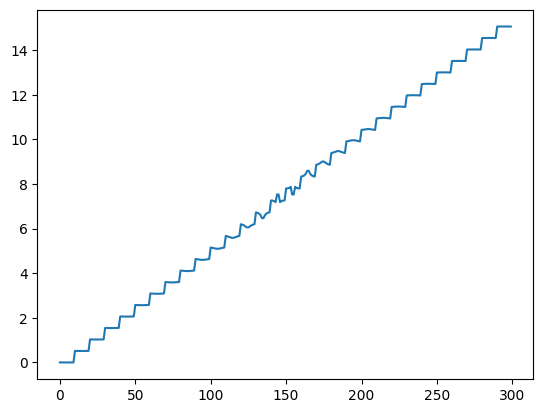

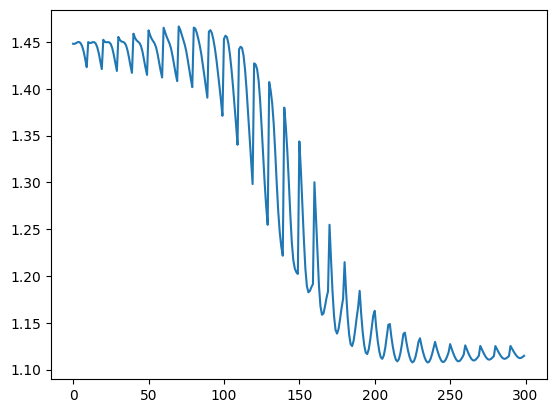

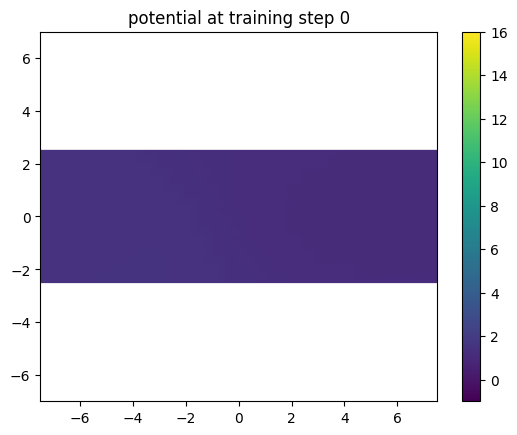

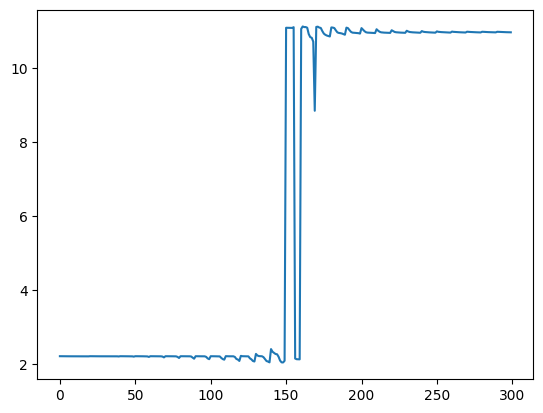

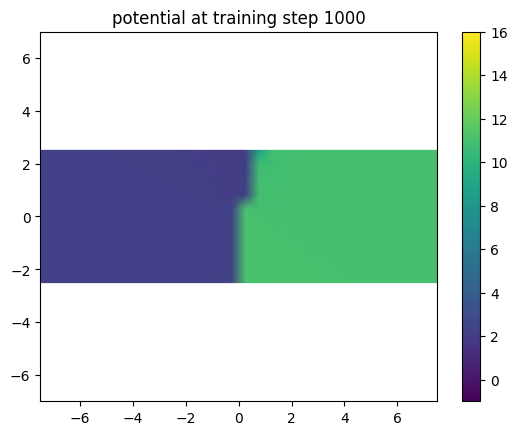

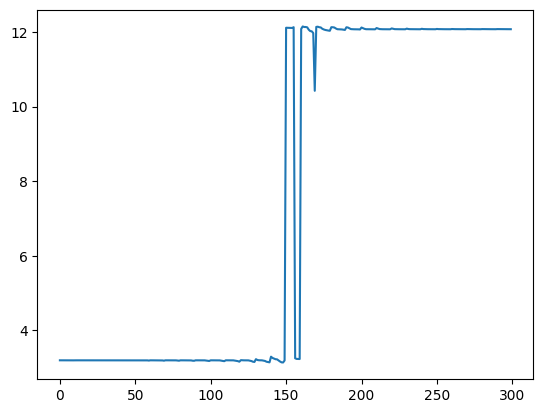

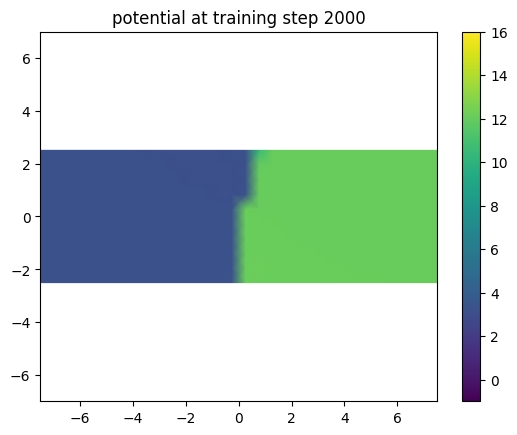

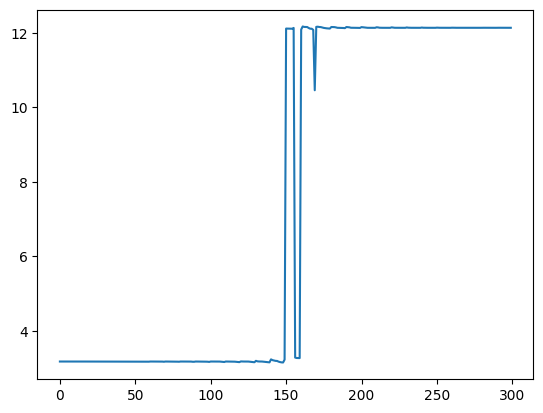

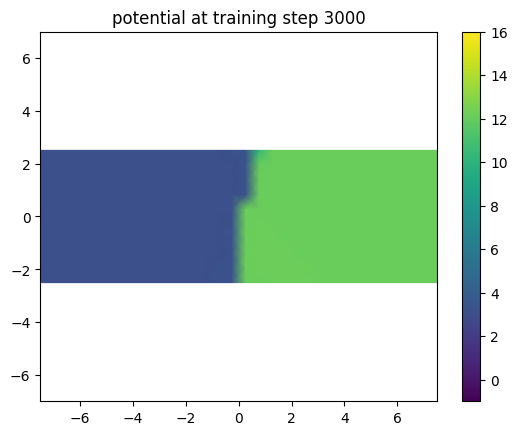

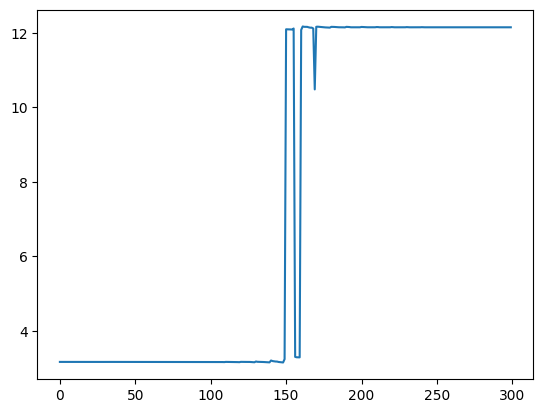

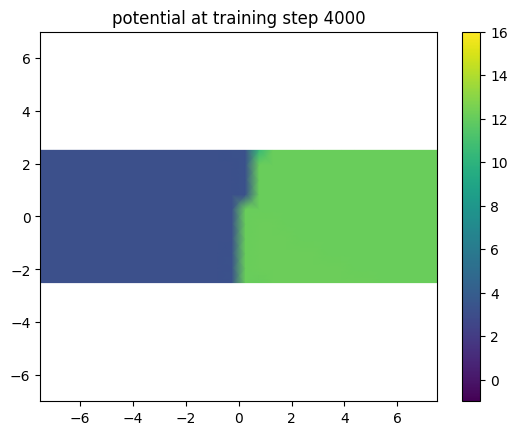

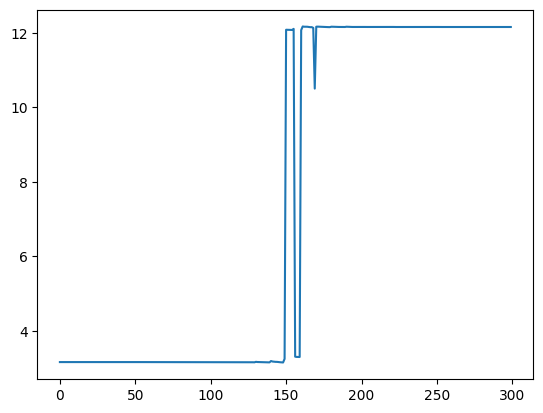

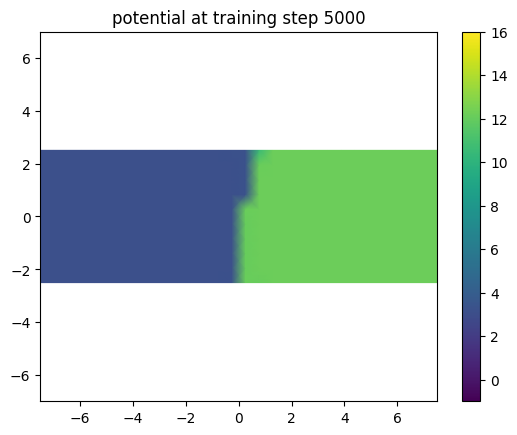

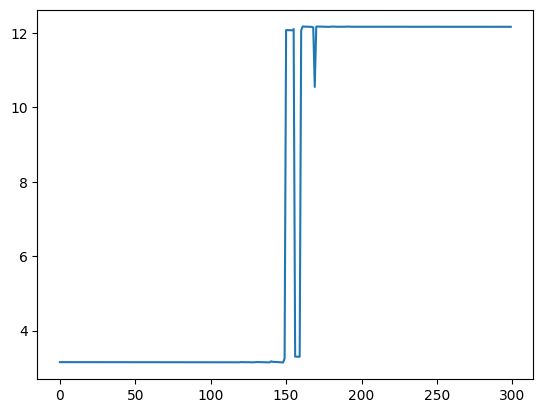

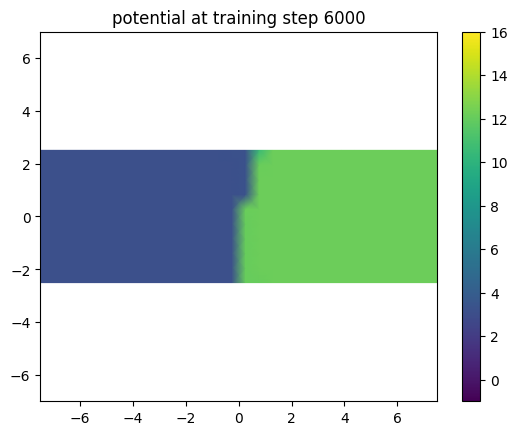

KeyboardInterrupt: ignored

In [43]:
torch.manual_seed(123)

# define a neural network to train
pinn = FullyConnected(2, 264, 1)

# define training points over the entire domain, for the physics loss
x_physics = torch.linspace(-5.5, 5.5, 20).requires_grad_(True)
y_physics = torch.linspace(-2, 2, 20).requires_grad_(True)
grid_x_physics, grid_y_physics = torch.meshgrid(x_physics, y_physics, indexing='ij')
grid_xy_physics = torch.stack((grid_x_physics.ravel(), grid_y_physics.ravel()))
grid_xy_physics = torch.transpose(grid_xy_physics, 0, 1)
print(grid_xy_physics.size())

# define data over the domain
x_data = torch.linspace(-7.5, 7.5, 30)
y_data = torch.linspace(-2.5, 2.5, 10)
grid_x_data, grid_y_data = torch.meshgrid(x_data, y_data, indexing='ij')

xy_data2 = torch.stack((grid_x_data.ravel(), grid_y_data.ravel()))
xy_data_final = torch.transpose(xy_data2, 0, 1)


# get analytical solution for defined data points
phi_exact, v_x_exact, v_y_exact = compute_analytical_solution((grid_x_data, grid_y_data), U=1, R=0.5)
plt.plot(phi_exact.ravel())
plt.show()

optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-2)
us = []
for i in range(15001):
    optimiser.zero_grad()

    # compute physics loss
    phi_pred = pinn(grid_xy_physics)
    grad_f = torch.autograd.grad(phi_pred, grid_xy_physics, grad_outputs=torch.ones_like(phi_pred), create_graph=True)[0]
    nabla_f = torch.autograd.grad(grad_f, grid_xy_physics, grad_outputs=torch.ones_like(grad_f), create_graph=True)[0]

    residual = torch.sum(nabla_f, 1)
    physics_loss = torch.mean(residual ** 2)

    # compute data loss
    phi_pred = pinn(xy_data_final)
    data_loss = torch.mean((phi_pred - phi_exact.ravel()) ** 2)

    # boundary loss
    """ TO BE INSERTED
    # No flux on walls.
    left_wall_pinn = pinn(left_wall_xys)
    right_wall_pinn = pinn(right_wall_xys)

    right_wall_grad = 0
     """

    # cylinder normal b.c.
    """
    grid_xy_cylinder = torch.from_numpy(cylinder_xys)
    print(grid_xy_cylinder)
    phi_pred_cylinder = pinn(grid_xy_cylinder)

    print("done")
    grad_f_cylinder = torch.autograd.grad(phi_pred_cylinder, cylinder_xys, grad_outputs=torch.ones_like(phi_pred_cylinder), create_graph=True)[0]
    nabla_f_cylinder = torch.autograd.grad(grad_f_cylinder, cylinder_xys, grad_outputs=torch.ones_like(grad_f_cylinder), create_graph=True)[0]
    residual_cylinder = torch.sum(nabla_f_cylinder, 1)
    cylinder_loss = torch.mean(residual_cylinder ** 2)
    """

    # backpropagate joint loss, take optimiser step
    lambda1 = 1e-4
    loss = lambda1 * data_loss + physics_loss # + cylinder_loss
    loss.backward()
    optimiser.step()

    # record U value
    #us.append(U.item())

    # plot the result as training progresses
    if i % 1000 == 0:
        phi = pinn(xy_data_final).detach()
        plt.plot(phi)
        plt.show()

        fig, ax = plt.subplots()

        phi = torch.reshape(phi, (30, 10))

        m = ax.pcolormesh(x_data, y_data, np.swapaxes(phi,0,1), shading='Gouraud', vmin=-1, vmax=16)
        #ax.contour(x_data, y_data, phi)
        plt.colorbar(m, ax=ax)
        ax.axis('equal')
        ax.set_title(f"potential at training step {i}")

        plt.show()

